In [6]:
from urllib.request import urlretrieve
from datetime import datetime
import pandas as pd

def get_historical_data_url(ticker):
    unix_oldest_date = 0
    unix_newest_date = int(datetime.now().timestamp())
    return f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={unix_oldest_date}&period2={unix_newest_date}&interval=1d&events=history&includeAdjustedClose=true"

get_historical_data_url("AAPL")

def download_data(ticker):
    url = get_historical_data_url(ticker)
    df = pd.read_csv(url)
    # filename = f"{ticker}.csv"
    # df.to_csv(filename)
    return df



RSI CALCULATOR


In [2]:
def get_gain_los(data):
    loss = []
    gain = []
    for i in range(len(data)):
        difference = data[i]-data[i-1]
        if(i != 0):
            if(difference <= 0):
                loss.append(-1 * difference)
            elif(difference > 0):
                gain.append(difference)
    return loss, gain

loss, gain = get_gain_los([20,19,50,45,68,46,65,65,84,52,57,65,98,12,34])
sum(gain)/len(gain), sum(loss)/len(loss)

(20.0, 24.333333333333332)

In [3]:
def get_average_gain_loss(data):
  loss, gain = get_gain_los(data)
  avg_loss = 0
  avg_gain = 0
  if(len(loss) != 0):
    avg_loss = sum(loss)/len(loss)

  if(len(gain) != 0):
    avg_gain = sum(gain)/len(gain)

  return avg_loss, avg_gain

def get_rsi(data):
    loss, gain = get_average_gain_loss(data)
    if loss != 0:
      rs = gain / loss
      rsi = 100 - (100 / (1 + rs))
      return rsi
    else:
      return 0

def get_rsi_column(data, count, onlyLast = False):
  rsi_row = []
  for i in range(len(data)):
    i += 1
    start = i - count
    if start < 0:
      start = 0
    rsi_value = (get_rsi(data[start:i]))
    if rsi_value != 0:
      rsi_row.append(rsi_value)
    else:
      rsi_row.append(0)
  return rsi_row


get_rsi_column([20,19,50,45,68,46,65,65,84,52,57,65,98,32,39], 14)

[0,
 0,
 96.875,
 91.17647058823529,
 90.0,
 74.3119266055046,
 72.27722772277227,
 77.65957446808511,
 76.66666666666666,
 65.71428571428572,
 61.78343949044585,
 59.32203389830508,
 62.16216216216217,
 48.42105263157895,
 42.02898550724638]

Berekenen van Bollinger bands

In [4]:
def calculate_boba_row(df,count, onlyLastOne=False):
  # df = data.copy()
  if not onlyLastOne:
    df['SMA'] = df['Open'].rolling(window=count).mean()
    df['SD'] = df['Open'].rolling(window=count).std()
  elif onlyLastOne:

    df['SMA'] = df['Open'][-count:].mean()
    df['SD'] = df['Open'][-count:].std()

  # Bereken Upper en Lower Bollinger Bands
  upper_band_row = df['SMA'] + (2 * df['SD'])
  lower_band_row = df['SMA'] - (2 * df['SD'])

  return upper_band_row, lower_band_row


Dataframe klaarmaken en ophalen

average volumes berekenen

In [5]:
def calculate_avg_volumes(df, count,onlyLastOne=False):
  # Bereken het gemiddelde volume van de voorgaande
  if not onlyLastOne:
    df['avg_volume'] = df['Volume'].rolling(window=count).mean()
    df['avg_open'] = df['Open'].rolling(window=count).mean()
  elif onlyLastOne:

    df['avg_volume'] = df['Volume'][-count:].mean()
    df['avg_open'] = df['Open'][-count:].mean()
  return df

rsi berekenen

In [6]:
def calculate_rsi_df(df, count, onlyLastOne=False):
    # Bereken de RSI-waarde
    df[f"Rsi{count}"] = get_rsi_column(df["Open"].array,count,onlyLastOne)
    return df

In [7]:
def calculate_boba_df(df, count, onlyLastOne=False):
  #Bereken bollinger bands
    df[f"lower_band_{count}"], df[f"upper_band_{count}"] = calculate_boba_row(df,count, onlyLastOne)
    return df

datum naar unix time

In [8]:
from datetime import datetime
def convert_dates_to_int(df):
     #Datum vervangen door int
  return int(datetime.strptime(df, "%Y-%m-%d").timestamp())

def convert_int_to_dates(df):
  return datetime.fromtimestamp(df).strftime("%Y-%m-%d")

In [41]:
def get_df_ready(df, count):
  print(df.info())
  #close mag niet weggesmeten worden anders is het onmogelijk om model te trainen
  #df = df.drop("Close", axis=1)
  df = df.drop("Adj Close", axis=1)
  df = df.drop("High", axis=1)
  df = df.drop("Low", axis=1)
  df = df.dropna()
  df = calculate_avg_volumes(df, count)
  df = calculate_rsi_df(df, count)
  df = calculate_boba_df(df, count)
  df['Date'] = df['Date'].apply(convert_dates_to_int)
  return df

def calculate_axis(df, target):
  X = df.drop(columns=[target])
  y = df[target]
  return X, y




Uitvoeren close predict algoritme

In [10]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_xgboost_model(X_train,y_train):
  gbm = xgb.XGBRegressor(max_depth=4, n_estimators=500, learning_rate=0.03)
  gbm.fit(X_train, y_train)
  return gbm

def test_xgboost(gbm, X_test, y_test):
  predictions = gbm.predict(X_test)
  solutions = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
  solutions_sorted = solutions.sort_index(ascending=True)
  print(solutions_sorted.iloc[-10:])
  mse = mean_squared_error(y_test, predictions)
  print("Mean Squared Error:", mse)

  return predictions

In [ ]:
# df = download_data("AAPL")
# df = get_df_ready(df);
# X,y = calculate_axis(df, "Close")
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# model = get_xgboost_model(X_train,y_train)
# test_xgboost(model,X_test,y_test)

Het voorspellen van de y-waardes (retourneert enkel y-waardes)

In [11]:
def predict_xgboost_close(gbm, X_test):

    # Make predictions
    predictions = gbm.predict(X_test)

    return predictions

Plotten van voorspelde tov reele waarde (OUD)


In [12]:
import matplotlib.pyplot as plt


# Plot werkelijke vs voorspelde waarden
def plot_prediction(X_test,y_test,y_pred):
  resultaten = pd.DataFrame({"Date": X_test.index, "Werkelijke": y_test, "Voorspeld": y_pred})
  resultaten = resultaten.sort_values(by="Date")  # Sorteer op tijdstempel als dat nog niet is gebeurd

  # Maak de lijngrafiek
  plt.figure(figsize=(10, 6))
  plt.plot(resultaten["Date"], resultaten["Werkelijke"], label="Werkelijke waarden", marker='o')
  plt.plot(resultaten["Date"], resultaten["Voorspeld"], label="Voorspelde waarden", marker='x')
  plt.xlabel("Datum")
  plt.ylabel("Waarde")
  plt.title("Werkelijke vs Voorspelde waarden")
  plt.xticks(rotation=45)  # Draai de datums voor leesbaarheid
  plt.legend()
  plt.grid(True)

  # Inzoomen op de laatste honderd waarden
  laatste_honderd = resultaten.iloc[-30:]  # Krijg de laatste honderd rijen
  plt.xlim(laatste_honderd["Date"].iloc[0], laatste_honderd["Date"].iloc[-1])  # Stel het bereik van de x-as in
  plt.ylim(150, 200)  # Beperk y-as van 150 tot 200

  plt.tight_layout()
  plt.show()

Retourneert de laatste rij van een gegeven dataframe (als een dataframe)

In [13]:
def get_last_row(X_values):
  row = X_values.iloc[-1:]
  return row

def get_before_last_row(X_values):
  row = X_values.iloc[-2]


  return row

Voorspellen van de standaard features ("Open","Volume","Date")

In [46]:
def add_new_row(df, count, volume_model):
  new_row = get_last_row(df)
  last_row = get_last_row(df)
  #open_prediction = open_model.predict(last_row)

  #Open vandaag = close van gisteren
  new_row["Open"] = last_row["Close"]

  #volume voorspellen maar eerst oude volume verwijderen voor acurate voorspelling
  last_row = last_row.drop("Volume",axis=1)
  print("pred volume")
  print(last_row)
  volume_prediction = volume_model.predict(last_row)
  print(volume_prediction)
  print("succes volume pred")

  #Volume vervangen
  new_row["Volume"] = volume_prediction;

  #De dag 1 dag opschuiven
  #!WAT ALS DE BEURS DE DAG EROP NIET OPEN IS
  new_row["Date"] = last_row["Date"] + 24*3600;

  count = count*2
  # rij toevoegen aan dataframe en dataframe nieuwe features berekenen
  df = pd.concat([df, new_row], ignore_index=True)
  df = calculate_avg_volumes(df, count, onlyLastOne=True)
  df = calculate_boba_df(df, count, onlyLastOne=True)
  df = calculate_rsi_df(df, count)
  return df


In [29]:
def predict_last_row_open(df,open_model):
  last_row = get_last_row(df)
  last_row = last_row.drop("Close",axis=1)

  open_prediction = open_model.predict(last_row)

  df.loc[df.index[-1], "Open"] = open_prediction[0]
  return df

In [ ]:
# df = get_df_ready(download_data("AAPL"))
# print(df.tail())
# X, y = calculate_axis(df, "Open")
# open_model = get_xgboost_model(X, y)
# X, y = calculate_axis(df, "Volume")
# volume_model = get_xgboost_model(X, y)
# df = predict_new_row(df, open_model, volume_model)
# print(df.tail())

Voorspellen van de standaard features van een aantal nieuwe rijen (retourneert alleen de nieuwe rijen als dataframe)

Ik heb dit zo gedaan zodat je kan zien op de grafiek wat de reele waarden zijn en wat de voorspelde waarden zijn


In [39]:
def predict_new_rows(count, df):
   #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & y
  X, y = calculate_axis(df, "Close")
  open_model = get_xgboost_model(X, y)



  X, y = calculate_axis(df, "Volume")
  print(X)
  volume_model = get_xgboost_model(X, y)

  #Het dataframe omzetten naar X & y waardes
  #Model maken adhv X & y
  #MOdel wordt hier gemaakt omdat je anders altijd een nieuwe rij maakt
  for i in range(count):
    df = add_new_row(df, count, volume_model)
    df = predict_last_row_open(df,open_model)
  return df

In [20]:
def split_train_test(X,y):
  total_size = len(X)

  # Bepaal het indexpunt waar de 80% grens ligt
  split_index = int(0.8 * total_size)

  # Splits de gegevens op basis van de index
  X_train, X_test = X[:split_index], X[split_index:]
  y_train, y_test = y[:split_index], y[split_index:]
  return X_train, X_test, y_train, y_test

Het printen van de nieuwe voorspelde waardes in een grafiek

In [ ]:
download_data("AAPL").drop("Close", axis=1)

,Date,Open,High,Low,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.099192,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.094017,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.087117,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.089273,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.091861,73449600
...,...,...,...,...,...,...
10899,2024-03-08,169.000000,173.699997,168.940002,170.729996,76114600
10900,2024-03-11,172.940002,174.380005,172.050003,172.750000,60139500
10901,2024-03-12,173.149994,174.029999,171.009995,173.229996,59825400
10902,2024-03-13,172.770004,173.190002,170.759995,171.130005,52437800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10907 entries, 0 to 10906
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10907 non-null  object 
 1   Open       10907 non-null  float64
 2   High       10907 non-null  float64
 3   Low        10907 non-null  float64
 4   Close      10907 non-null  float64
 5   Adj Close  10907 non-null  float64
 6   Volume     10907 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 596.6+ KB
None
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
0       345427200    0.128348    0.128348         NaN         NaN   0.000000   
1       345686400    0.122210    0.121652         NaN         NaN   0.000000   
2       345772800    0.113281    0.112723         NaN         NaN   0.000000   
3       345859200    0.115513    0.115513         NaN         NaN  22.855973   
4       345945600    0.118862    0.118862         NaN         N

<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume  avg_open      Rsi20  \
10906  1710806400  174.339996  176.080002  69206415.0  176.3035  46.781155   

            SMA        SD  lower_band_20  upper_band_20  
10906  176.3035  5.280639     186.864777     165.742222  
[63274012.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume  avg_open      Rsi20  \
10907  1710892800  175.613129  176.080002  70293630.6  176.0105  47.148284   

            SMA        SD  lower_band_20  upper_band_20  
10907  176.0105  5.111291     186.233082     165.787918  
[75937784.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10908  1710979200  175.417953  176.080002  71475909.8  175.617156  44.203915   

              SMA        SD  lower_band_20  upper_band_20  
10908  175.617156  4.799401     185.215958     166.018354  
[78843800.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10909  1711065600  175.831497  176.080002  73162114.8  175.137554  47.836318   

              SMA        SD  lower_band_20  upper_band_20  
10909  175.137554  4.260372     183.658299      166.61681  
[78631704.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10910  1711152000  174.969849  176.080002  75050330.0  174.817129  44.125371   

              SMA        SD  lower_band_20  upper_band_20  
10910  174.817129  3.925946      182.66902     166.965237  
[78843800.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10911  1711238400  174.734406  176.080002  76276575.0  174.510621  47.080604   

              SMA        SD  lower_band_20  upper_band_20  
10911  174.510621  3.638376     181.787373     167.233869  
[81820320.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open     Rsi20  \
10912  1711324800  173.571045  176.080002  77919896.0  174.121841  48.98994   

              SMA        SD  lower_band_20  upper_band_20  
10912  174.121841  3.116635     180.355112     167.888571  
[81820320.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10913  1711411200  172.640121  176.080002  75176782.0  173.736893  52.119557   

              SMA        SD  lower_band_20  upper_band_20  
10913  173.736893  2.623761     178.984416     168.489371  
[78235744.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date        Open       Close  avg_volume    avg_open      Rsi20  \
10914  1711497600  172.611954  176.080002  75414169.2  173.391399  57.774125   

              SMA        SD  lower_band_20  upper_band_20  
10914  173.391399  2.245718     177.882834     168.899964  
[73976288.]
succes volume pred
success
succes


<ipython-input-46-8c6dbfc8dcc0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Open"] = last_row["Close"]
<ipython-input-46-8c6dbfc8dcc0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_row["Volume"] = volume_prediction;
<ipython-input-46-8c6dbfc8dcc0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

pred volume
             Date       Open       Close  avg_volume    avg_open      Rsi20  \
10915  1711584000  174.77919  176.080002  75037478.6  173.214497  68.788256   

              SMA        SD  lower_band_20  upper_band_20  
10915  173.214497  2.154475     177.523448     168.905547  
[83377608.]
succes volume pred
success
succes
             Date        Open       Close       Volume  avg_volume  \
10902  1710288000  172.770004  171.130005   52488700.0  74449739.0   
10903  1710374400  172.910004  173.000000   72913500.0  74449739.0   
10904  1710460800  171.169998  172.619995  121664700.0  74449739.0   
10905  1710720000  175.570007  173.720001   75604200.0  74449739.0   
10906  1710806400  174.339996  176.080002   55130000.0  74449739.0   
10907  1710892800  175.613129  176.080002   63274012.0  74449739.0   
10908  1710979200  175.417953  176.080002   75937784.0  74449739.0   
10909  1711065600  175.831497  176.080002   78843800.0  74449739.0   
10910  1711152000  174.969849  17

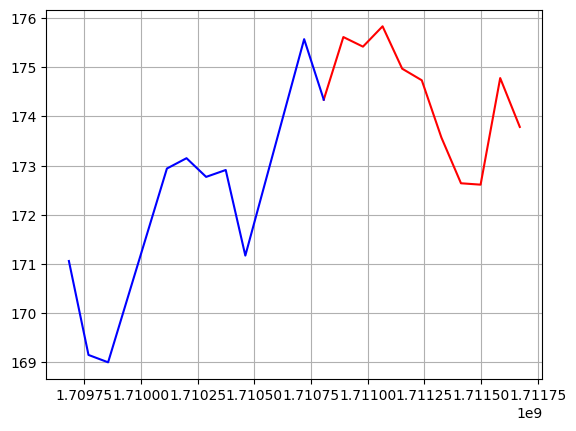

In [49]:
def print_new_predictions(count,name):
  df = download_data(name)
  df = get_df_ready(df, count*2);
  prediction = predict_new_rows(count, df)
  print(prediction.tail(15))
  plt.plot(prediction['Date'].iloc[-(count+1):] ,prediction["Open"].iloc[-(count+1):] , color='r')
  plt.plot(df["Date"].iloc[-10:], df["Open"].iloc[-10:], label="Werkelijke waarden", color='b')
  plt.grid()
  plt.show()

print_new_predictions(10,"AAPL")